# Overview

In the remote data science landscape, the data science and machine learning tasks are collaborated between two main actors

- Data Owner
- Data Scientist

The network that facilitates this collaboration is called **Domain Server** or **Domain Node**.

As the name suggests, a **Data Owner** owns the data that will be used for remote data science. They make their datasets available for study in a secured and protected way to an outside party they may or may not fully trust to have good intentions. This outside party is usually a data scientist.

**Data Scientists** are end users who desire to perform computations or answer a specific question using one or more data owners' secured datasets with remote execution.

Enabling external data scientists to extract meaningful value from the data, allows access to more data which otherwise is kept private, limiting scientific advancement, reproducibility of studies and transparency for various social issues.

By the end of this tuturial, 
- **you will be able to run the complete workflow of a remote data science pipeline in a small scale**.

# Hello Syft

PySyft is a python library containing a set of data serialization and remote code execution APIs which mimic existing popular Data Science tools while working interchangeably with existing popular data types. It enables data scientists query for their data related questions on sensitive or proprietary data in a secure and privacy-preserving way. The python package for PySyft is called `syft`. 

### Let's consider the following scenario:

Imagine that you are a data scientist who is conducting a study on the average age of patients across different countries when they were diagnosed with breast cancer for the first time. For your study, you are looking for hospital data to analyse. After careful research, you have selected one regional cancer hospital in the USA, one in the UK and one in India. 

Now, you just need to get a hold of the cancer patient data from these hospitals and query their average age! 

But wait! These data are highly sensitive and private to the respective hospitals. There is a high possibility that those hospitals are not willing to share their data with external data scientists like yourself. 

This is where `syft` comes to the rescue.

In the world of `syft`, data scientists and data owners are able to work collaboratively to carry forward this study in a safe, secured way by complying with the individual data privacy policies of the respective hospitals. 

Welcome to the world of **Syft**!

### The Workflow

The process kicks-off on the Data Owner's end by deploying **two** completely separate servers. These servers are reffered to as `high-side domain` and `low-side domain`. 

- **High-side domain** contains the original data which holds private and sensitive information
- **Low-side domain** contains a mock or synthetically generated version of the original data, which is identical in data schema, data types, data structure and data distribution etc., except the values are fake or made-up

The **high-side domain** is within the firewall and holds private data. Only data owner employees have access to this server (such as the **Data Manager**). The **low-side domain** on the other hand is outside the firewall and holds the mock/synthetic data. This server can be accessed by select external parties like a data scientist (via firewall/vpn access) but it only contains mock/synthetic information. 

For the sake of simplicity, in this tutorial we will use **Data Owner** and **Data Manager** interchangeably.

![caption](https://github.com/znreza/PySyft/blob/znreza/trial_1/notebooks/low-side-high-side.png?raw=true)

The data owner or data manager creates an account for the external data scientist to give access to the mock data. 

The data scientist then gets into the **low-side domain** using their account, takes a look at the mock data and analyse it like any other normal dataset, designs their research questions accordingly and finally submits a **code request** to the data manager. The **code request** contains information including the entire code (as a `syft` function) and the pointer to the mock data that was used for writing the code. 

The data manager receives the code request on their end, and reviews it to make sure that the code is not adversarial in any way. If everything looks good, they accept the request and run the same code on the `true` data on the **high-side domain**, add a certain amount of **noise** to the result and finally share the **noisy or masked result** with the data scientist as their answer for the study.

In this first tutorial, we will cover this workflow in the following order,

- Data Owner workflow
    - upload mock data to low-side domain
    - create data scientist account
- Data Scientist Workflow
    - write query against mock data
    - submit code for review on the data owner side
- Data Owner workflow
    - review code and approve

# The Code

### Install `syft`

In [ ]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/zarreen


✅ The installed version of syft==0.8.1b6 matches the requirement >=0.8.1b0 and the requirement <0.9


### Access to Domain Servers

In this tutorial, for the sake of demonstration, we will be using in-memory workers as dummy servers. For details of deploying a server on your own using `syft` and `hagrid`, please refer to the `quickstart` tutorials.

Let's run the workflow for the Data Owner of the regional hospital in the USA.

In [3]:
node = sy.orchestra.launch(name="hello-syft-usa-server", port=9082, reset=True)

Starting hello-syft-usa-server server on 0.0.0.0:9082
SQLite Store Path:
!open file:///tmp/0cdb61a5b8d248d69eceaa067523492c.sqlite

Waiting for server to start. Done.


### Data owner: Upload data to Low-side Domain

The data owner has the following original data of 5 five cancer patients in their hospital.

In [4]:
import pandas as pd

In [5]:
usa_data = {'Patient_ID': ['011', '015', '022', '034', '044'],
     'Age': [40, 39, 35, 60, 25]
      }

usa_df = pd.DataFrame(usa_data)
usa_df

,Patient_ID,Age
0,011,40
1,015,39
2,022,35
3,034,60
4,044,25


Now based on the original data, the data owner will generate a synthetic or fake version of this dataset. They can add any amount of noise to the fake values. Let's say in this fake version, they are adding `+10` to each of the ages.

In [6]:
usa_mock_data = {'Patient_ID': ['1', '2', '3', '4', '5'],
     'Age': [50, 49, 45, 70, 35]
      }

usa_mock_df = pd.DataFrame(usa_mock_data)
usa_mock_df

,Patient_ID,Age
0,1,50
1,2,49
2,3,45
3,4,70
4,5,35


Now the data owner will upload this mock data to the low-side domain.

In [7]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

In [8]:
dataset = sy.Dataset(name="usa-mock-data",
                     asset_list=[sy.Asset(name="ages", data=usa_df, mock=usa_mock_df, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)

100%|█████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


Uploading: ages


<class 'syft.service.response.SyftSuccess'>: Dataset Added

### Data Owner: Create Account for Data Scientist

In [9]:
root_domain_client.register(name="Jane Doe", email="janedoe@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

<class 'syft.service.response.SyftSuccess'>: User successfully registered!

### Data Scientist: Login to Low-side Domain

In [10]:
external_ds = sy.login(url='0.0.0.0:9082', email="janedoe@caltech.edu", password="abc123")
external_ds

Logged into hello-syft-usa-server as <janedoe@caltech.edu>


/home/zarreen/ziwi_env/lib/python3.10/site-packages/IPython/core/formatters.py:367: FormatterWarning: text/html formatter returned invalid type <class 'type'> (expected <class 'str'>) for object: <SyftClient - hello-syft-usa-server <0cdb61a5b8d248d69eceaa067523492c>: HTTPConnection: http://0.0.0.0:9082>
  warnings.warn(


<SyftClient - hello-syft-usa-server <0cdb61a5b8d248d69eceaa067523492c>: HTTPConnection: http://0.0.0.0:9082>

#### Load Mock Data

In [11]:
external_ds.datasets

,type,id,name,url
0,syft.service.dataset.dataset.Dataset,e0ca1acf1274425caeefe758d0c786f3,usa-mock-data,None


In [12]:
dataset = external_ds.datasets[-1]
dataset

```python
Syft Dataset: usa-mock-data
Assets:
	ages: None

```

In [13]:
asset = dataset.assets["ages"]
asset

```python
Asset: ages
Pointer Id: 87362d493e704fd5bc9f8df8506a1dd9
Description: None
Total Data Subjects: 0
Shape: (5, 2)
Contributors: 0

```

In [14]:
mock_df = asset.mock
mock_df

,Patient_ID,Age
0,1,50
1,2,49
2,3,45
3,4,70
4,5,35


### Data Scientist: Write Query on Mock Data

In [15]:
import matplotlib.pyplot as plt

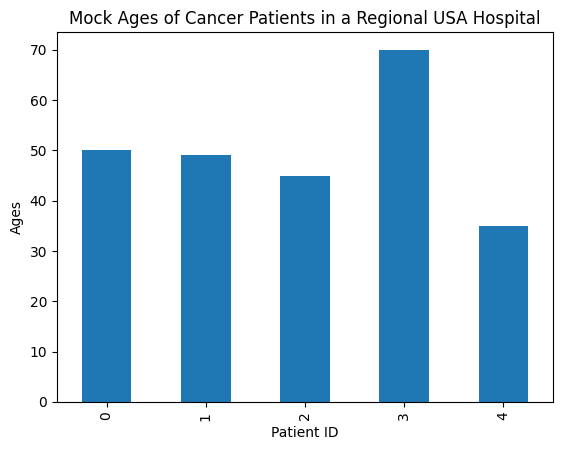

In [16]:
mock_df['Age'].plot(kind="bar")
plt.xlabel("Patient ID")
plt.ylabel("Ages")
plt.title("Mock Ages of Cancer Patients in a Regional USA Hospital")
plt.show()

In [17]:
age_sum = mock_df['Age'].mean()
print(age_sum)

49.8


In [18]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_mean_age(df):
    return df['Age'].mean()

### Data Scientist: Submit Code Request for Review

In [19]:
req = external_ds.code.request_code_execution(get_mean_age)
req

```python
class Request:
  id: str = 56c24f33ed4844bbb468b88c548c43ca
  requesting_user_verify_key: str = 7584ccdd162853f0fe1e7a2069b282cabd2d3139a9701896ffa0a37807b0643f
  approving_user_verify_key: str = None
  request_time: str = 2023-06-08 07:28:15
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 0cdb61a5b8d248d69eceaa067523492c
  request_hash: str = "954033f4c674cb8b982cfce33629a652c396a10b68fa9046b554ee72e2b7f3ed"
  changes: str = [syft.service.request.request.UserCodeStatusChange]

```

In [20]:
submitted_code = external_ds.code[0]
# submitted_code

In [21]:
assert external_ds.code.get_all()

#### Create and submit project
In order to submit the code, the data scientist needs to create a project first.

In [22]:
project_create = sy.Project(
    name="My data science code on USA cancer mock data",
    description="Hi, I would like to know the average age of cancer patients in your data.",
    shareholders=[external_ds],
    user_email_address = "janedoe@caltech.edu",
    users = [external_ds]
)
project_create

```python
class ProjectSubmit:
  id: str = None
  name: str = "My data science code on USA cancer mock data"
  description: str = "Hi, I would like to know the average age of cancer patients in your data."
  shareholders: str = [<🔑 aec42e3e @ 🟢 0cdb61a5>]
  project_permissions: str = set()
  state_sync_leader: str = None
  consensus_model: str = <syft.service.project.project.DemocraticConsensusModel object at 0x7f1b084670a0>
  leader_node_route: str = syft.service.network.routes.HTTPNodeRoute
  user_email_address: str = "janedoe@caltech.edu"
  users: str = [<🔑 7584ccdd @ 🟢 0cdb61a5>]

```

In [23]:
projects = project_create.start()
assert len(projects) == 1

In [24]:
project = projects[0]
project

```python
class Project:
  id: str = 756d65fc51be4a729bcac9525ab34275
  name: str = "My data science code on USA cancer mock data"
  description: str = "Hi, I would like to know the average age of cancer patients in your data."
  shareholders: str = [<🔑 aec42e3e @ 🟢 0cdb61a5>]
  project_permissions: str = {'OWNER_aec42e3ed0374103099bec56820ddddc76b633d9e268c927cdc20a20c39d0d68'}
  state_sync_leader: str = <🔑 aec42e3e @ 🟢 0cdb61a5>
  leader_node_peer: str = syft.service.network.node_peer.NodePeer
  consensus_model: str = <syft.service.project.project.DemocraticConsensusModel object at 0x7f1b08547580>
  store: str = {}
  permissions: str = {}
  events: str = []
  event_id_hashmap: str = {}
  start_hash: str = "df22072494703ee44178a559a8f803eed7a03714636d3344659065f153421e9d"
  user_signing_key: str = 2c12e7c54ec0949963865a4b22392f1f17059611fd740002564dd45348652d57
  user_email_address: str = "janedoe@caltech.edu"
  users: str = [<🔑 7584ccdd @ 🟢 0cdb61a5>]

```

In [25]:
project.add_request(request=req)

<class 'syft.service.response.SyftSuccess'>: Request created successfully

In [26]:
assert len(project.events) == 1
assert isinstance(project.events[0], sy.service.project.project.ProjectRequest)

The code request is successfully submitted!

### Data Owner: Review Code and Execute Function

In [27]:
from syft.service.project.project import Project

In [28]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

#### Get messages

In [29]:
messages = root_domain_client.api.services.messages.get_all_unread()
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,0b854cb861c44ff7a1200829a4a5b814,Approval Request,MessageStatus.UNREAD,2023-06-08 07:28:15,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,5c03b2f6b8a841279226810c6d273ccd,Project Approval,MessageStatus.UNREAD,2023-06-08 07:28:23,<<class 'syft.service.project.project.Project'...


In [30]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]
project_message

```python
class Message:
  id: str = 5c03b2f6b8a841279226810c6d273ccd
  subject: str = "Project Approval"
  node_uid: str = 0cdb61a5b8d248d69eceaa067523492c
  from_user_verify_key: str = 7584ccdd162853f0fe1e7a2069b282cabd2d3139a9701896ffa0a37807b0643f
  to_user_verify_key: str = aec42e3ed0374103099bec56820ddddc76b633d9e268c927cdc20a20c39d0d68
  created_at: str = 2023-06-08 07:28:23
  status: str = MessageStatus.UNREAD
  linked_obj: str = <<class 'syft.service.project.project.Project'>: 756d65fc51be4a729bcac9525ab34275@<Node: 0cdb61a5b8d248d69eceaa067523492c>

```

#### Review Code and Policies

In [31]:
request = project_message.link.events[0].request
func = request.changes[0].link
# func

In [32]:
op = func.output_policy_type
op

syft.service.policy.policy.OutputPolicyExecuteOnce

#### Execute function on real data

In [33]:
get_col_user_function = func.unsafe_function

In [34]:
real_data = root_domain_client.datasets[0].assets[0].data
real_result = get_col_user_function(df=real_data)
print(real_result)

39.8


#### Share the real result with the Data Scientist

In [35]:
result = request.accept_by_depositing_result(real_result)
print(result)
assert isinstance(result, sy.SyftSuccess)

message='Request 56c24f33ed4844bbb468b88c548c43ca changes applied'


### Data Scientist: Fetch Real Result

In [37]:
external_ds = sy.login(url='0.0.0.0:9082', email="janedoe@caltech.edu", password="abc123")
external_ds

Logged into hello-syft-usa-server as <janedoe@caltech.edu>


<SyftClient - hello-syft-usa-server <0cdb61a5b8d248d69eceaa067523492c>: HTTPConnection: http://0.0.0.0:9082>

In [38]:
asset = external_ds.datasets[0].assets[0]
asset

```python
Asset: ages
Pointer Id: 87362d493e704fd5bc9f8df8506a1dd9
Description: None
Total Data Subjects: 0
Shape: (5, 2)
Contributors: 0

```

In [39]:
external_ds.code[0].status

{NodeView(node_name='hello-syft-usa-server', verify_key=aec42e3ed0374103099bec56820ddddc76b633d9e268c927cdc20a20c39d0d68): <UserCodeStatus.EXECUTE: 'execute'>}

In [40]:
result_ptr = external_ds.code.get_mean_age(df=asset)
# result_ptr

In [41]:
real_result = result_ptr.get_from(external_ds)
print(real_result)

39.8


**That's a success!! The external data scientist was able to know the average age of breast cancer patients in a USA regional hospital, without having to access or even look at the real data.**

Once you are done with this tutorial, you can safely shut down the servers as following,

In [42]:
node.land()

Stopping hello-syft-usa-server
